# Project: Blackjack playing strategy using Monte Carlo Methods

In this notebook, we will write implementations of many Monte Carlo (MC) algorithms to get the optimal policy of playing Blackjack.  

### Introduction

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.

    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).

    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.

    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1

To get more idea about the environment, please go to its [Github](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) implementation.

### Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [2]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [3]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(8, 1, False)
End game! Reward:  -1.0
You lost :(

(16, 10, False)
End game! Reward:  -1
You lost :(

(9, 5, False)
(13, 5, False)
End game! Reward:  1.0
You won :)



### MC Prediction: State Values

In this section, we will write our own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [4]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [5]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((11, 5, False), 1, 0), ((15, 5, False), 1, 0), ((20, 5, False), 0, 0.0)]
[((20, 10, False), 0, 1.0)]
[((14, 3, False), 1, -1)]


Now, we are ready to write our own implementation of MC prediction.  We will implement the every-visit MC prediction.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.



In [6]:
# Test blocks
# gamma = 0.9
# for i, state in enumerate(state):
#     discounts = np.array([math.pow(gamma, i) for i in range(len(reward))])
#     print(sum(reward[i:]*discounts[i:]))


In [7]:
# Test blocks
# r = np.array([1,1,1,-1])
# s = [1,1,1,1]
# d = np.array([1,0.9,0.81,0.729])
# for i in range(len(s)):
#     print(sum(r[i:]*d[:len(d)-i]))

In [8]:
%matplotlib inline
from collections import defaultdict
import numpy as np
import sys
import math

# Implement every-visit Monte Carlo prediction method (can easily be modified for first-visit MC)

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    counts = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        episode = generate_episode(env)
        # Separate states, actions and rewards
        states, actions, rewards = zip(*episode)
        # Discounted factors to be used
        discounts = np.array([math.pow(gamma, i) for i in range(len(rewards))])
        max_num_states = len(discounts)
        
        # Iterating over each state in the episode
        for i,state in enumerate(states):
            # Check if the state has been visited before or not
            if state in returns.keys():
                # Add the return from the state to the total returns 
                returns[state] += sum(rewards[i:]*discounts[:max_num_states-i])
                # Keep count of number of times a state is visited
                counts[state] += 1
            else:
                returns[state] = sum(rewards[i:]*discounts[:max_num_states-i])
                counts[state] = 1
    # Calculate value for each state by dividing total return for each state over various episodes by the 
    # number of times each state was visited
    V ={}
    for state, val in returns.items():
        V[state] = val/counts[state]
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)


Episode 500000/500000.

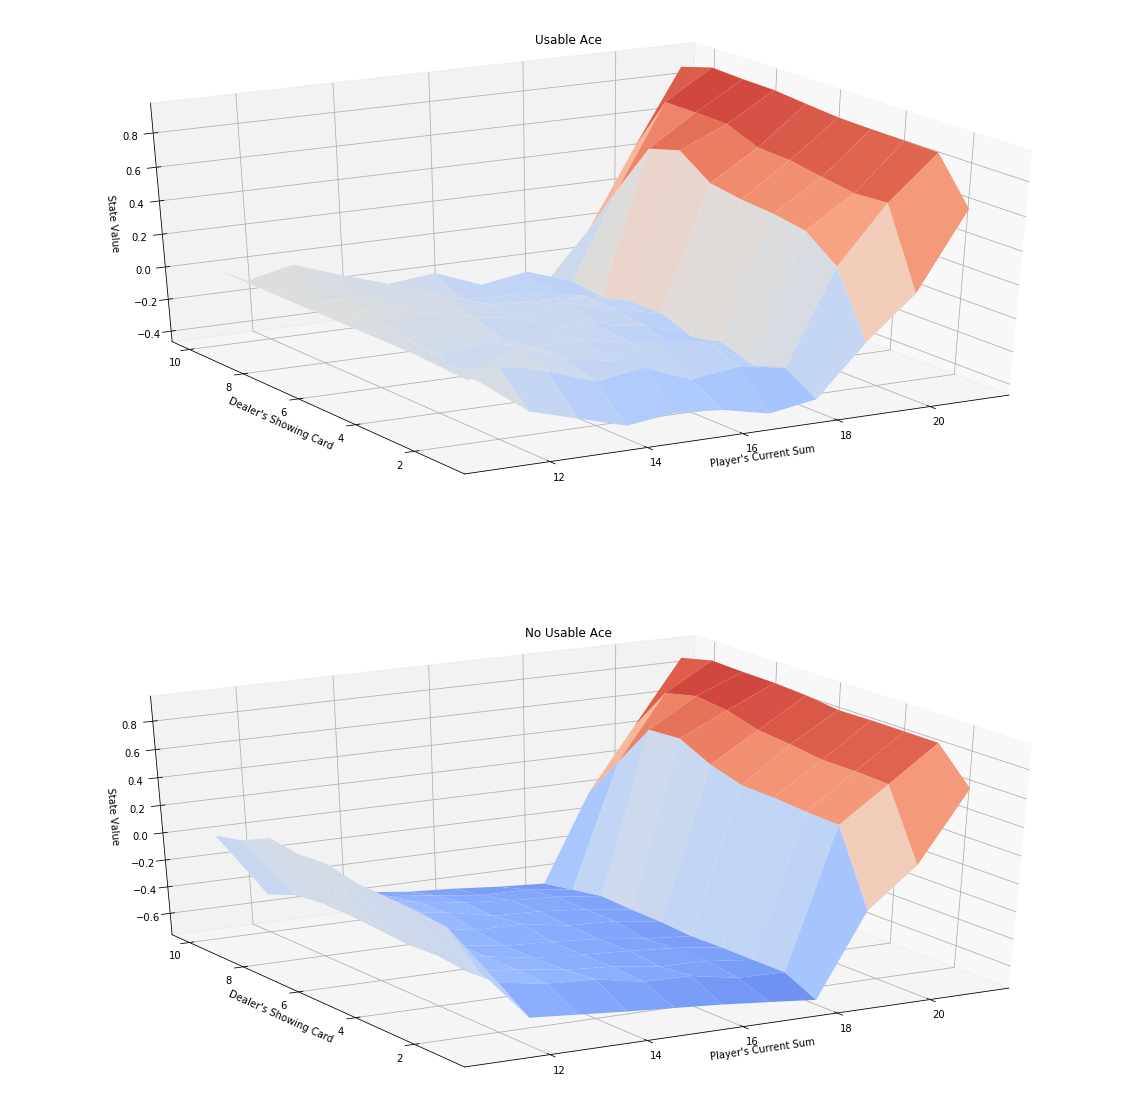

In [7]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### MC Prediction: Action Values

In this section, we will write our own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, we are ready to write our own implementation of MC prediction.  

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [10]:
np.zeros(env.action_space.n)

array([ 0.,  0.])

In [11]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episodes
        episode = generate_episode_from_limit_stochastic(env)
        # Separate state, actions and rewards
        states, actions, rewards = zip(*episode)
        # Get discount values
        discounts = np.array([math.pow(gamma, i) for i in range(len(rewards))])
        max_num_states = len(states)
        
        for i, state in enumerate(states):
            N[state][actions[i]] += 1
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:max_num_states-i])
            # Repeated Q calculations of cumulative values
            Q[state][actions[i]] = returns_sum[state][actions[i]]/N[state][actions[i]]
        
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.


Episode 500000/500000.

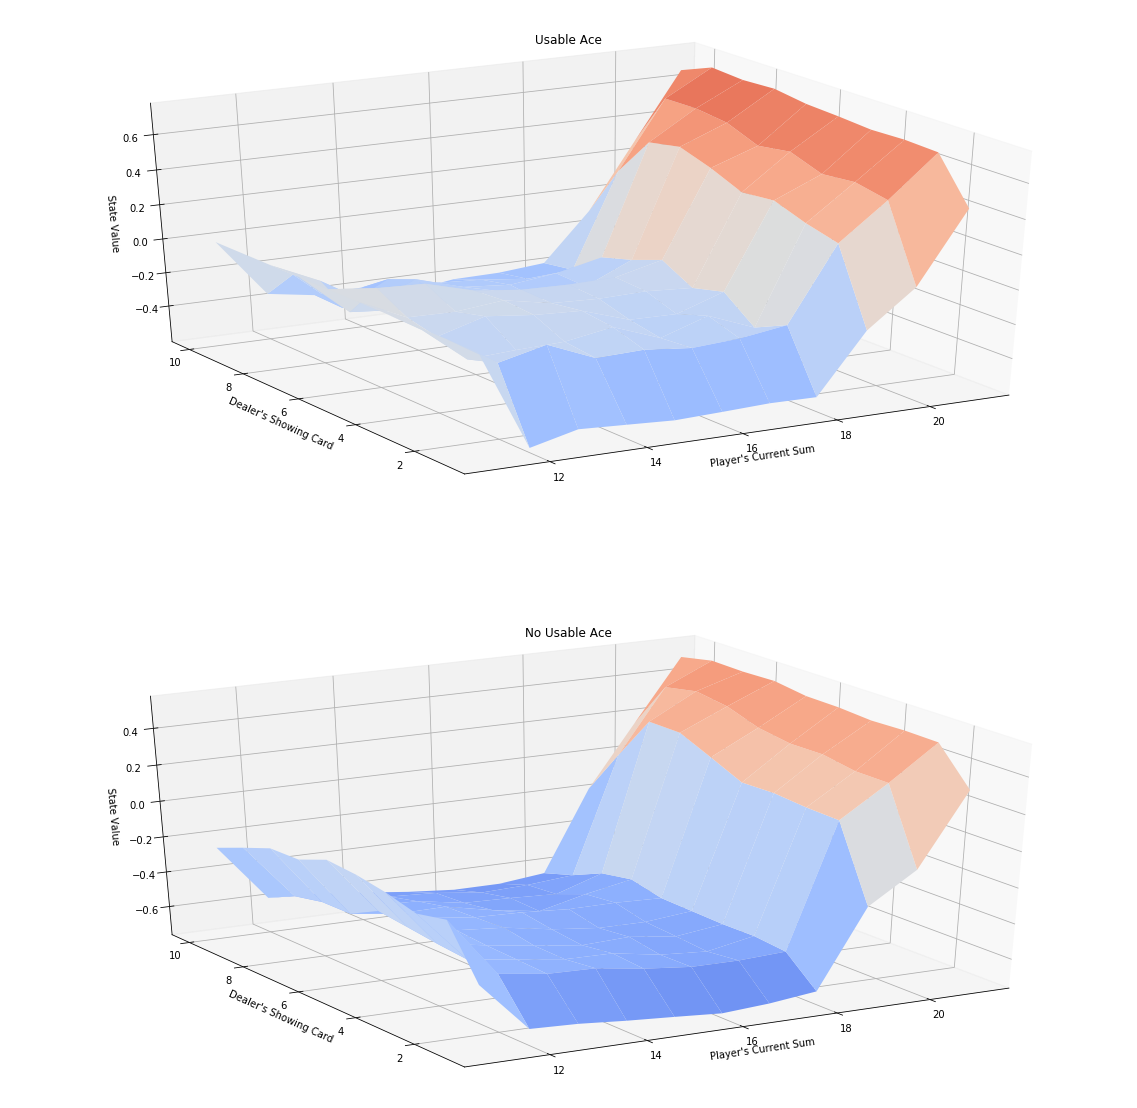

In [81]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

###  MC Control: GLIE

In this section, we will write an implementation of constant-$\alpha$ MC control.  

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.


In [12]:
def get_current_policy(Q_current_state, epsilon, nA):
    # Set all initial probabilities to epsilon/number of available actions
    policy_current = np.ones(nA) * (epsilon / nA)
    # Get the best action from the current state values
    best_action = np.argmax(Q_current_state)
    # Set the probability of best action to (1 - epsilon + (epsilon/number of available actions))
    policy_current[best_action] = 1 - epsilon + (epsilon / nA)
    
    return policy_current

In [13]:
def generate_episode_by_epsilon_policy(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        # Select action based on policy if the state has been previously encountered, else select random action
        action = np.random.choice(np.arange(nA), p = get_current_policy(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode        

In [14]:
def GLIE(env, Q, N, episode, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([math.pow(gamma, i) for i in range(len(rewards))])
    max_num_states = len(rewards)
    
    for i, state in enumerate(states):
        old_N = N[state][actions[i]]
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + (1.0/(old_N+1))*(sum(rewards[i:]*discounts[:max_num_states-i]) - old_Q)
        N[state][actions[i]] += 1
    return Q, N    

In [15]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Set the epsilon value
        epsilon = (1.0/((i_episode/8000)+1))
        
        # Generate episode based on epsilon value
        episode = generate_episode_by_epsilon_policy(env, Q, epsilon, nA)
        
        # Get updated Q, N values after processing the episode
        Q, N = GLIE(env, Q, N, episode, gamma)
        
    # Get new policy based on the new state-action values
    policy = dict((k, np.argmax(v)) for k,v in Q.items())
    
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [17]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

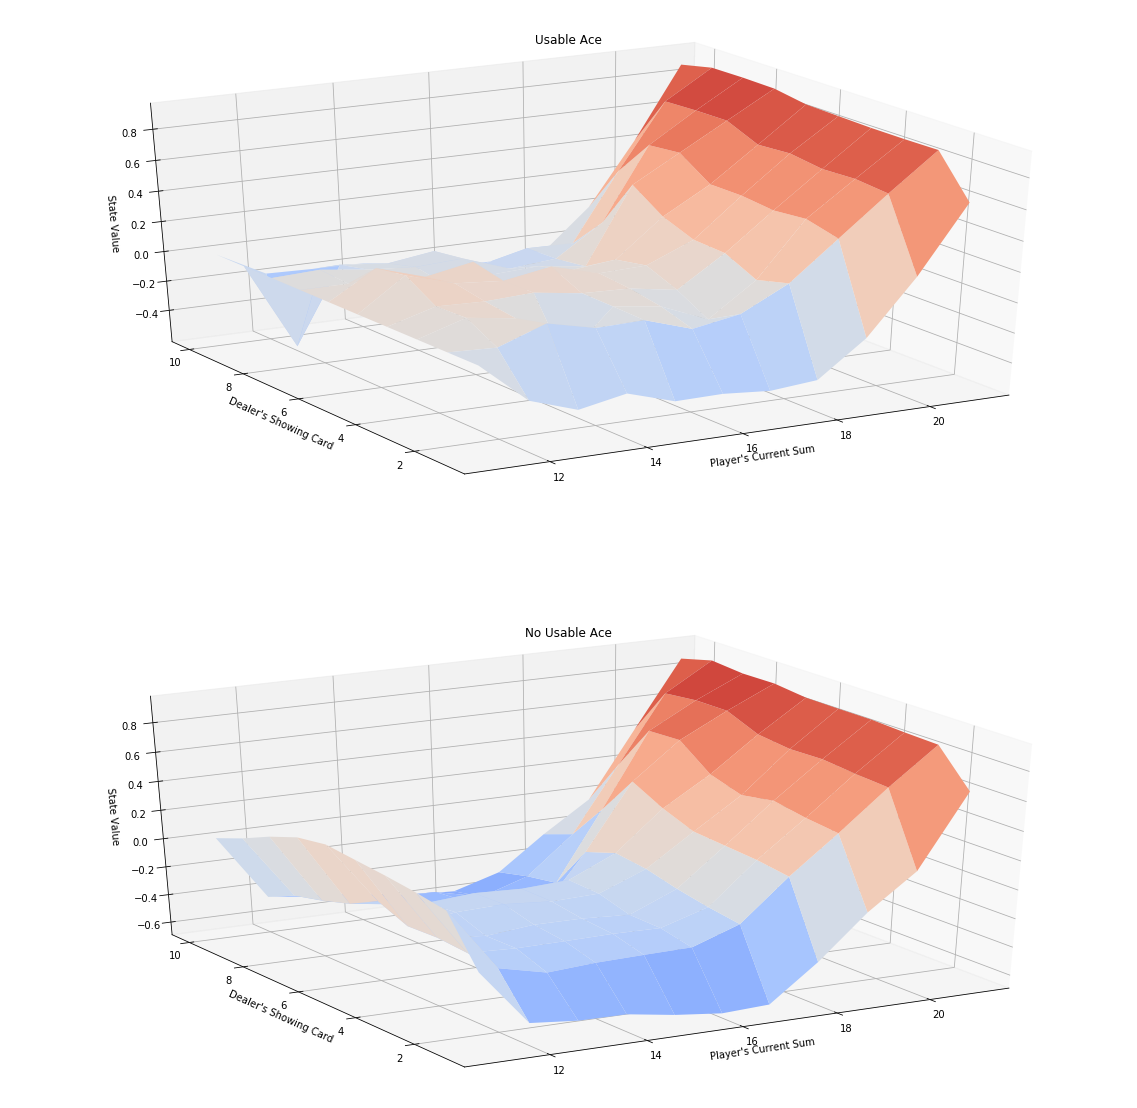

In [18]:
from plot_utils import plot_blackjack_values

# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

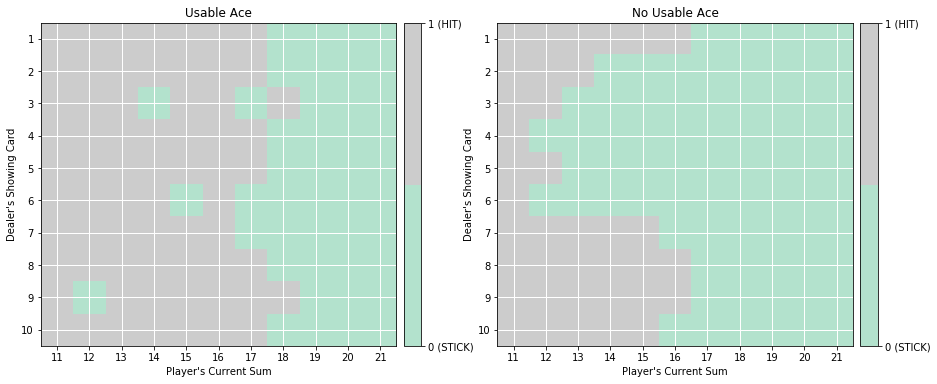

In [19]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of this [textbook](http://go.udacity.com/rl-textbook).  Compare your final estimate to the optimal policy.


### MC Control: Constant-$\alpha$

In this section, we will write an implementation of constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.


In [26]:
def GLIE_with_alpha(env, episode, Q, gamma, alpha):
    states, actions, rewards = zip(*episode)
    discounts = np.array([math.pow(gamma, i) for i in range(len(rewards))])
    max_num_state = len(states)
    
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        current_return = sum(rewards[i:]*discounts[:max_num_state-i])
        Q[state][actions[i]] = old_Q + alpha*(current_return - old_Q)
    return Q    

In [27]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Set the epsilon value for the current episode
        epsilon = 1/((i_episode/5000)+1)
        
        # Generate an episode
        episode = generate_episode_by_epsilon_policy(env, Q, epsilon, nA)
        
        # Get Q values
        Q = GLIE_with_alpha(env, episode, Q, gamma, alpha)
        
    # Get policy
    policy = dict((k, np.argmax(v)) for k,v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [28]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

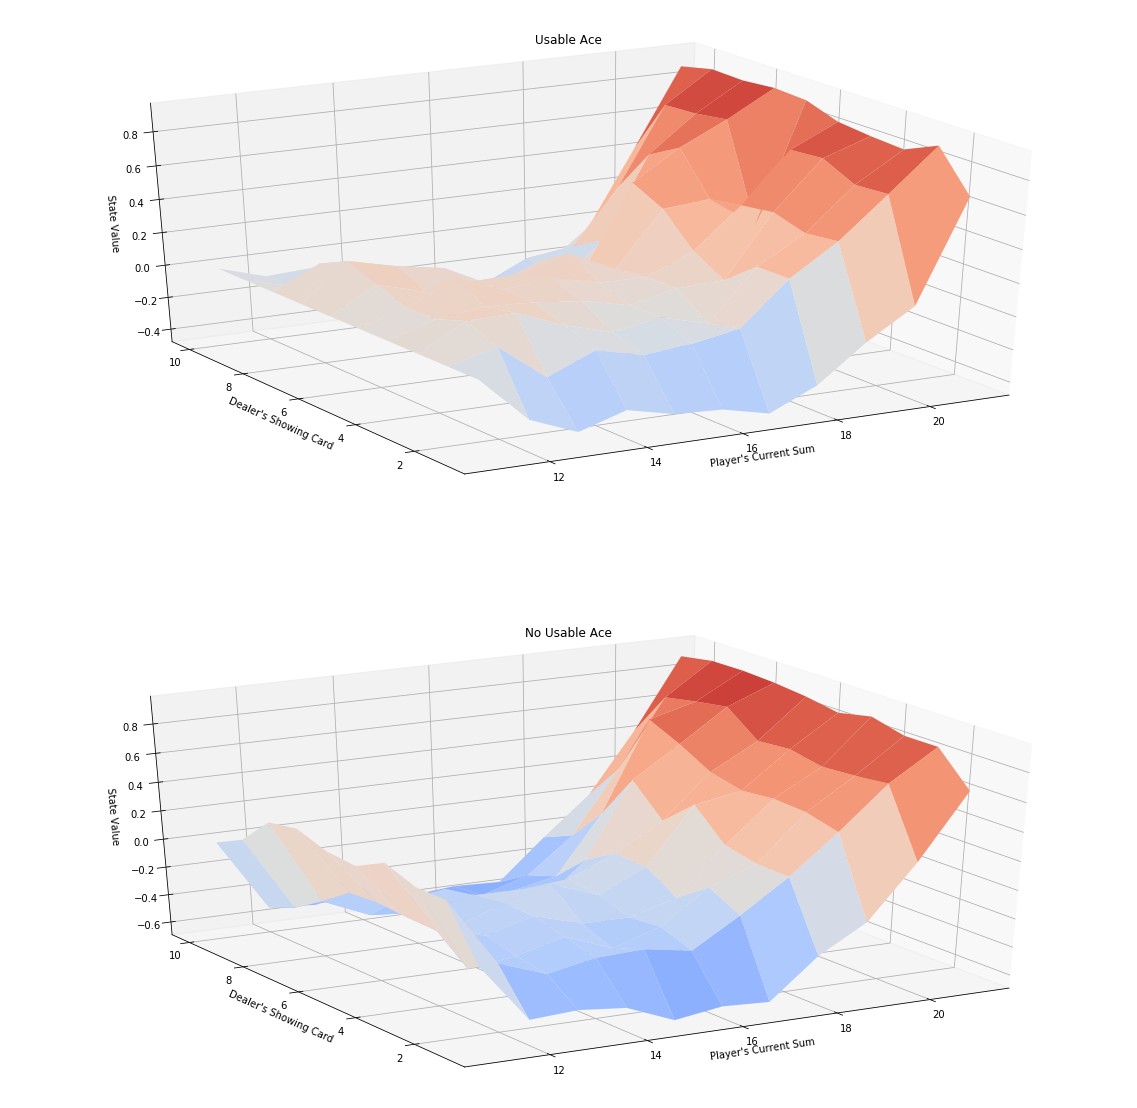

In [29]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

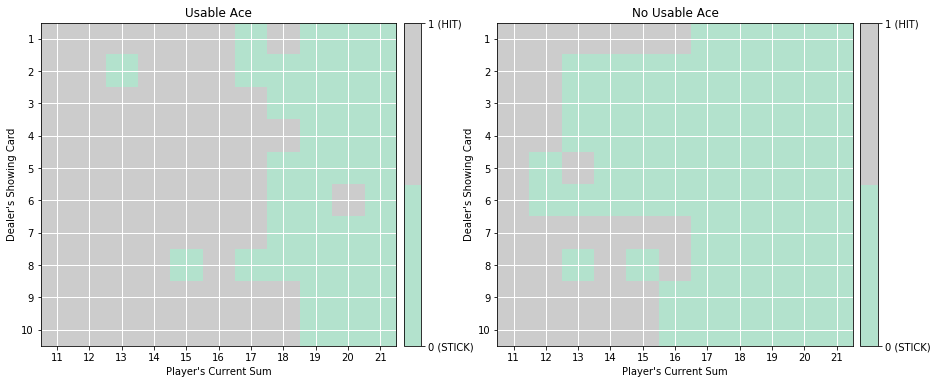

In [30]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook). Compare your final estimate to the optimal policy.